## Selection and plotting of KRAS Case study subset

This notebook is to evaluate the metrics (MSE, E-distance, and Augur) for separating KRAS targeting treatments against KRAS cell line context.

In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_dir = "/large_storage/gilbertlab/aidanw/projects/tahoe/data"

### Stratifying patients by KRAS mutation

In [3]:
## open parquet in python
cl_meta = pd.read_parquet(f"{data_dir}/metadata/cell_line_metadata.parquet", engine='pyarrow')
cl_meta.head(2)

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor


In [13]:
cell_lines = cl_meta['cell_name'].unique()
annot = pd.DataFrame(columns=['KRAS', 'KRAS_G12C', 'KRAS_non_G12C', 'KRAS_label'], index=cell_lines)
annot.index.name = 'cell_name'

## All KRAS
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
annot.loc[kras_driven_cell_lines, 'KRAS'] = 1

## KRAS G12C
g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")['cell_name'].unique()
annot.loc[g12c, 'KRAS_G12C'] = 1

## KRAS non-G12C
not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'")['cell_name']
annot.loc[not_g12c, 'KRAS_non_G12C'] = 1

## KRAS label: kras_g12c, kras_non_g12c, no_kras
not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")['cell_name'].unique()
annot.loc[not_kras_driven, 'KRAS_label'] = 'no_kras'
annot.loc[g12c, 'KRAS_label'] = 'kras_g12c'
annot.loc[not_g12c, 'KRAS_label'] = 'kras_non_g12c'

#confirm that all cell lines have been labeled
assert annot['KRAS_label'].notna().all() 

annot = annot.fillna(0)
annot.to_csv(f"{data_dir}/metadata/kras_labels.csv")
annot.head(2)

/tmp/ipykernel_1980503/852910316.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annot = annot.fillna(0)


,KRAS,KRAS_G12C,KRAS_non_G12C,KRAS_label
cell_name,,,,
A549,1,0,1,kras_non_g12c
HOP-92,0,0,0,no_kras


In [16]:
coi = ['HS-578T', 'HEC-1-A', 'RKO']
annot.index.isin(coi).sum()

np.int64(3)

## Plotting Vision scores

In [17]:
vision = sc.read_h5ad(f'{data_dir}/20250417.diff_vision_scores_pseudobulk.public.h5ad', backed='r')

picked_drugs_short = ['RMC-6236','Adagrasib','Celecoxib', 'Homoharringtonine', 'Dinaciclib']
idx = vision.obs.index[(vision.obs['concentration'] == 5) & (vision.obs['drug'].isin(picked_drugs_short))]
vis = vision[:, vision.var_names.str.contains('KRAS')].to_memory()
vis = vis[idx, :]

vis.obs[['Cell_Name_Vevo', 'drug']] = vis.obs[['Cell_Name_Vevo', 'drug']].astype(str)
vis.obs.set_index(['Cell_Name_Vevo', 'drug'], inplace=True)

visdf = vis.to_df().reset_index()
visdf = visdf.groupby(['Cell_Name_Vevo', 'drug']).mean().reset_index()
visdf.head(2)

/tmp/ipykernel_1980503/1963996864.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  vis.obs[['Cell_Name_Vevo', 'drug']] = vis.obs[['Cell_Name_Vevo', 'drug']].astype(str)


,Cell_Name_Vevo,drug,gs_HALLMARK_KRAS_SIGNALING,gs_SINGH_KRAS_DEPENDENCY_SIGNATURE,gs_KRAS.DF.V1,gs_KRAS.AMP.LUNG_UP.V1,gs_KRAS.300_UP.V1,gs_KRAS.50_UP.V1,gs_KRAS.600_UP.V1,gs_KRAS.600.LUNG.BREAST_UP.V1,...,gs_KRAS.BREAST_UP.V1_UP,gs_KRAS.BREAST_UP.V1_DOWN,gs_KRAS.KIDNEY_UP.V1_UP,gs_KRAS.KIDNEY_UP.V1_DOWN,gs_KRAS.LUNG_UP.V1_UP,gs_KRAS.LUNG_UP.V1_DOWN,gs_KRAS.LUNG.BREAST_UP.V1_UP,gs_KRAS.LUNG.BREAST_UP.V1_DOWN,gs_KRAS.PROSTATE_UP.V1_UP,gs_KRAS.PROSTATE_UP.V1_DOWN
0,A-172,Adagrasib,-0.010446,0.003038,-0.036494,-0.051783,0.023198,0.062342,0.033281,-0.015761,...,-0.047729,-0.054294,0.116765,0.118621,-0.042372,0.058843,-0.073296,0.010660,-0.021882,0.044455
1,A-172,Celecoxib,-0.000230,0.123946,-0.005836,-0.039471,-0.002686,0.000034,0.016126,0.028860,...,0.051219,-0.027062,-0.023882,0.092801,0.023867,0.097968,0.049751,0.048168,-0.026249,0.007842


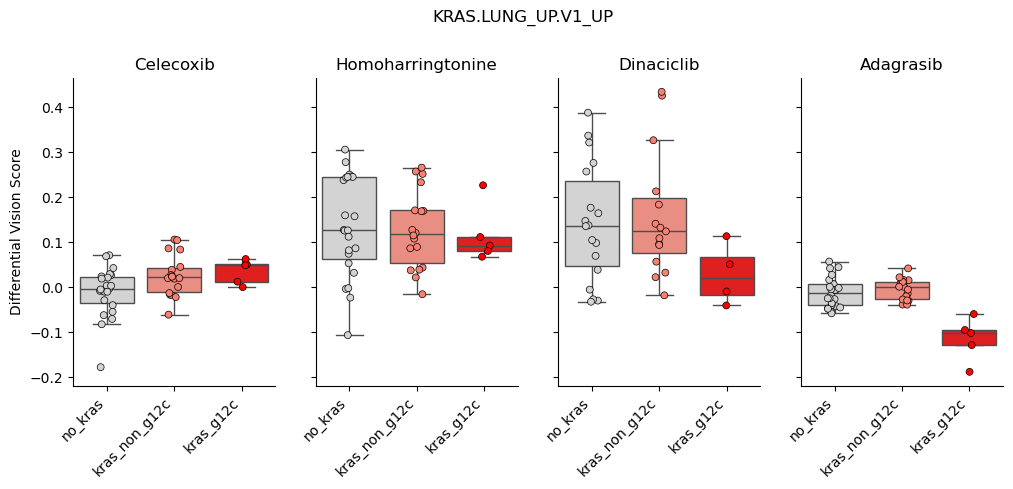

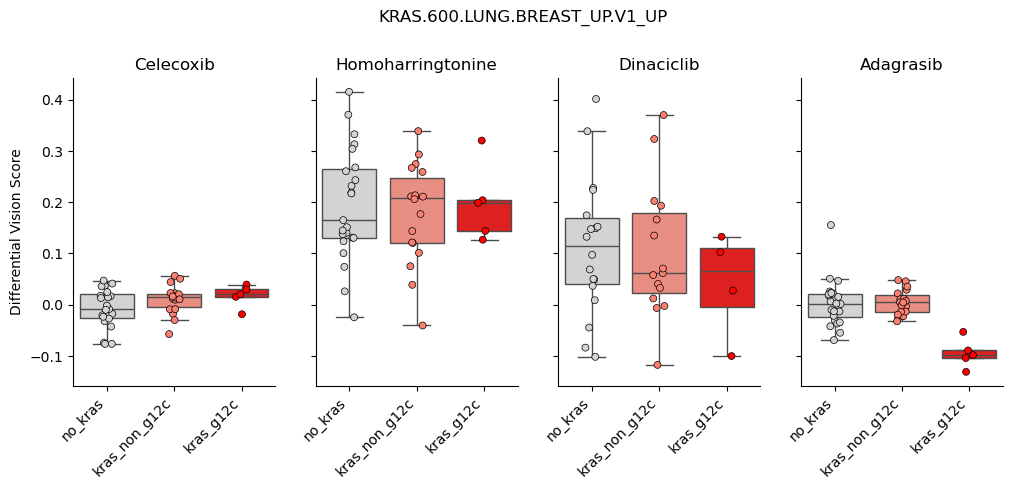

In [42]:
metrics = {}
vis_gs = ['gs_KRAS.LUNG_UP.V1_UP', 'gs_KRAS.600.LUNG.BREAST_UP.V1_UP']
picked_drugs = ['Celecoxib', 'Homoharringtonine', 'Dinaciclib', 'Adagrasib']

# palette = {1: 'salmon', 0: 'lightgrey'}
palette = {'kras_g12c': 'red', 'kras_non_g12c': 'salmon', 'no_kras': 'lightgrey'}

for m in vis_gs:
	df = visdf.pivot(index='Cell_Name_Vevo', columns='drug', values=m)
	df = pd.merge(df, annot, left_index=True, right_index=True)

	
	nplot = len(picked_drugs)
	fig, axs = plt.subplots(1, nplot, figsize=(nplot*3, 4), sharey=True)
	sns.despine()
	for drug, ax in zip(picked_drugs, axs.flatten()):
		sns.boxplot(data=df, x='KRAS_label', y=drug, ax=ax, hue='KRAS_label', palette = palette, legend=False, fliersize=0)
		sns.stripplot(data=df, x='KRAS_label', y=drug, ax=ax, hue='KRAS_label', palette = palette, legend=False, edgecolor='black', linewidth=0.5)
		ax.set_xticks(ax.get_xticks())
		ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
		ax.set_title(drug)
		ax.set_xlabel('')
		ax.set_ylabel('Differential Vision Score')
	fig.suptitle(m.replace('gs_', ''), y=1.05)
	plt.show()
	# # # visdf.loc[visdf[['Cell_Name_Vevo', 'drug']].duplicated(keep=False)].sort_values(['Cell_Name_Vevo', 'drug'])
	# # metrics[gs].columns = drug_meta5.reset_index().set_index('drug')['index'].loc[metrics[gs].columns] #set columns to the 'drugname_drugconc' annot